# $D_{s0}^{*}(2317)^+\to D_s^+\pi^0$ production study
## $D_{s0}^+$ yields
### Data analysis
#### MVA selection
##### BDT training

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



## RDataFrame definition

In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import os
from particle import Particle
import mplhep
from matplotlib import pyplot as plt
from sklearn.ensemble import  AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyML')
import RooPyFit as rpf
import RooPyShort as rsh
import RooPyML as rml

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()

%jsroot on

Welcome to JupyROOT 6.26/06
2023-10-21 16:41:00.712293
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

Graphs directory already exists


In [3]:
Data_MagU18_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagUp/2018/'
Data_MagD18_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2018/'
Data_MagU17_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagUp/2017/'
Data_MagD17_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2017/'
Data_MagD16_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2016/'

nfiles = len(os.listdir(Data_MagU18_path))

data_for_train = set([Data_MagU18_path + "DsJ_Data_MagU18_" + str(i) + ".root" for i in range(int(nfiles/10))])
  
Data_files = "DsJ_*.root"
dtt = "DsPi02ggTuple"

tdf_data = ROOT.RDataFrame(dtt+"/DecayTree", Data_MagU18_path+Data_files)
  
tdf_data_train = ROOT.RDataFrame(dtt+"/DecayTree", data_for_train)

tdf_data = tdf_data.Define("Ds0M", "Ds0_M - Ds_M + 1969 - piz_M + 135")
tdf_data = tdf_data.Define("deltaR_Dspiz", "deltaR(Ds_ETA, Ds_PHI, piz_ETA, piz_PHI)")
tdf_data = tdf_data.Define("deltaR_Dsg1", "deltaR(Ds_ETA ,Ds_PHI, gamma_1_ETA, gamma_1_PHI)")
tdf_data = tdf_data.Define("deltaR_Dsg2", "deltaR(Ds_ETA ,Ds_PHI, gamma_2_ETA, gamma_2_PHI)")
tdf_data = tdf_data.Define("deltaR_g1g2", "deltaR(gamma_1_ETA, gamma_1_PHI, gamma_2_ETA, gamma_2_PHI)")
tdf_data = tdf_data.Define("asympt_Dspiz", "asym_PT(Ds_PT, piz_PT)") 
tdf_data = tdf_data.Define("asympt_Dsg1", "asym_PT(Ds_PT, gamma_1_PT)") 
tdf_data = tdf_data.Define("asympt_Dsg2", "asym_PT(Ds_PT, gamma_2_PT)")
tdf_data = tdf_data.Define("asympt_g1g2", "asym_PT(gamma_1_PT, gamma_2_PT)")
tdf_data = tdf_data.Define("asymeta_Dspiz", "asym_ETA(Ds_ETA, piz_ETA)") 
tdf_data = tdf_data.Define("asymeta_Dsg1", "asym_ETA(Ds_ETA, gamma_1_ETA)") 
tdf_data = tdf_data.Define("asymeta_Dsg2", "asym_ETA(Ds_ETA, gamma_2_ETA)")
tdf_data = tdf_data.Define("asymeta_g1g2", "asym_ETA(gamma_1_ETA, gamma_2_ETA)")

tdf_data_train = tdf_data_train.Define("Ds0M", "Ds0_M - Ds_M + 1969 - piz_M + 135")
tdf_data_train = tdf_data_train.Define("deltaR_Dspiz", "deltaR(Ds_ETA, Ds_PHI, piz_ETA, piz_PHI)")
tdf_data_train = tdf_data_train.Define("deltaR_Dsg1", "deltaR(Ds_ETA ,Ds_PHI, gamma_1_ETA, gamma_1_PHI)")
tdf_data_train = tdf_data_train.Define("deltaR_Dsg2", "deltaR(Ds_ETA ,Ds_PHI, gamma_2_ETA, gamma_2_PHI)")
tdf_data_train = tdf_data_train.Define("deltaR_g1g2", "deltaR(gamma_1_ETA, gamma_1_PHI, gamma_2_ETA, gamma_2_PHI)")
tdf_data_train = tdf_data_train.Define("asympt_Dspiz", "asym_PT(Ds_PT, piz_PT)") 
tdf_data_train = tdf_data_train.Define("asympt_Dsg1", "asym_PT(Ds_PT, gamma_1_PT)") 
tdf_data_train = tdf_data_train.Define("asympt_Dsg2", "asym_PT(Ds_PT, gamma_2_PT)")
tdf_data_train = tdf_data_train.Define("asympt_g1g2", "asym_PT(gamma_1_PT, gamma_2_PT)")
tdf_data_train = tdf_data_train.Define("asymeta_Dspiz", "asym_ETA(Ds_ETA, piz_ETA)") 
tdf_data_train = tdf_data_train.Define("asymeta_Dsg1", "asym_ETA(Ds_ETA, gamma_1_ETA)") 
tdf_data_train = tdf_data_train.Define("asymeta_Dsg2", "asym_ETA(Ds_ETA, gamma_2_ETA)")
tdf_data_train = tdf_data_train.Define("asymeta_g1g2", "asym_ETA(gamma_1_ETA, gamma_2_ETA)")

### MonteCarlo

In [4]:
priv = False
Filt = False

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds0_files = "Ds0DsPi0*.root"
MC_Ds1_files = "Ds1DsstPi0*.root"
MC_Dsst_files = "DsstDsPi0*.root"
dtt = "DsPi02ggTuple"

tdf_Ds0_raw = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+MC_Ds0_files)
tdf_Ds0_raw = tdf_Ds0_raw.Define("Ds0M", "Ds0_M - Ds_M + 1969 - piz_M + 135")
tdf_Ds0_raw = tdf_Ds0_raw.Define("deltaR_Dspiz", "deltaR(Ds_ETA, Ds_PHI, piz_ETA, piz_PHI)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("deltaR_Dsg1", "deltaR(Ds_ETA ,Ds_PHI, gamma_1_ETA, gamma_1_PHI)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("deltaR_Dsg2", "deltaR(Ds_ETA ,Ds_PHI, gamma_2_ETA, gamma_2_PHI)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("deltaR_g1g2", "deltaR(gamma_1_ETA, gamma_1_PHI, gamma_2_ETA, gamma_2_PHI)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("asympt_Dspiz", "asym_PT(Ds_PT, piz_PT)") 
tdf_Ds0_raw = tdf_Ds0_raw.Define("asympt_Dsg1", "asym_PT(Ds_PT, gamma_1_PT)") 
tdf_Ds0_raw = tdf_Ds0_raw.Define("asympt_Dsg2", "asym_PT(Ds_PT, gamma_2_PT)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("asympt_g1g2", "asym_PT(gamma_1_PT, gamma_2_PT)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("asymeta_Dspiz", "asym_ETA(Ds_ETA, piz_ETA)") 
tdf_Ds0_raw = tdf_Ds0_raw.Define("asymeta_Dsg1", "asym_ETA(Ds_ETA, gamma_1_ETA)") 
tdf_Ds0_raw = tdf_Ds0_raw.Define("asymeta_Dsg2", "asym_ETA(Ds_ETA, gamma_2_ETA)")
tdf_Ds0_raw = tdf_Ds0_raw.Define("asymeta_g1g2", "asym_ETA(gamma_1_ETA, gamma_2_ETA)")
tdf_Ds0 = rsh.Ds0_TRUE_MM_def(tdf_Ds0_raw)

### Pre-selection

In [ ]:
pi0_pT_cut = "piz_PT > 1100"
pi0_window = "abs(piz_M-135) < 15"
Ds_window = "abs(Ds_M-1969) < 20"
gamma_cuts = "gamma_1_CL > 0.5 && gamma_2_CL > 0.5"
nPVs_cut = "nPVs == 1"

pre_sel_data = pi0_pT_cut+"&&"+pi0_window+"&&"+Ds_window+"&&"+gamma_cuts+"&&"+nPVs_cut
pre_sel_MC = pi0_pT_cut+"&&"+pi0_window+"&&"+Ds_window+"&&"+gamma_cuts+"&&"+nPVs_cut

tdf_data_sel = tdf_data.Filter(pre_sel_data+"&&"+"Ds0M>2100 && Ds0M<2600")

print(f"Entries data: ", tdf_data_sel.Count().GetValue())

tdf_data_sel_train = tdf_data_train.Filter(pre_sel_data+"&&"+"Ds0M>2100 && Ds0M<2600")

### Signal RDF $\to$ MCmatching

In [ ]:
xlabel_mass = "#it{M}(#it{D_{s}^{+}#pi^{0}}) [MeV/c^{2}]"
ylabel = "A.U"
title = "Ds0DsPi0 MC"

In [ ]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds0 = TRUEID_dtt["Ds0DsPi0"]

tdf_sig = tdf_Ds0.Filter(TRUEID_Ds0+"&&"+pre_sel_data)

print(f"Signal candidates:", tdf_sig.Count().GetValue())

### Background dataset $\to$ asymetric data sidebands

In [ ]:
side_bands_cut = "Ds0M < 2270 | Ds0M > 2400"
signal_region_cut = "Ds0M > 2100 && Ds0M < 2600"

tdf_bkg = tdf_data_train.Filter(pre_sel_data+"&&"+signal_region_cut)
tdf_bkg = tdf_bkg.Filter(side_bands_cut)

print(f"Background candidates:", tdf_bkg.Count().GetValue())

## Train set preparation

### Training features

In [ ]:
all_features = ["gamma_1_CL", "gamma_2_CL", "gamma_1_Prs", "gamma_2_Prs",
                "gamma_1_ShowerShape", "gamma_2_ShowerShape",
                "deltaR_g1g2", "asympt_g1g2", "asymeta_g1g2",
                "Ds_ENDVERTEX_CHI2", "Ds_IPCHI2_OWNPV", "Ds_FDCHI2_OWNPV", "Ds_0.40_nc_mult",
                "deltaR_Dsg1", "asympt_Dsg1", "asymeta_Dsg1",
                "deltaR_Dsg2", "asympt_Dsg2", "asymeta_Dsg2",
                "deltaR_Dspiz", "asympt_Dspiz", "asymeta_Dspiz"]

base_features = ["gamma_1_CL", "gamma_2_CL",
                 "gamma_1_ShowerShape", "gamma_2_ShowerShape", "Ds_0.40_nc_mult"]

In [ ]:
base = False

if base:
    training_features = base_features
else:
    training_features = base_features + ["asympt_Dsg1", "asympt_Dsg2"]

features = all_features + ["Ds0M", "piz_PT"]

### Train dataset

In [11]:
# Signal pandas dataframe
df_sig = rsh.rdf_to_pdf(tdf_sig, training_features)
df_sig = df_sig.copy()
df_sig["type"] = 1

In [12]:
# Background pandas dataframe
df_bkg = rsh.rdf_to_pdf(tdf_bkg, training_features)
df_bkg = df_bkg.copy()
df_bkg["type"] = 0

In [13]:
# Data pandas dataframe
df_data = rsh.rdf_to_pdf(tdf_data_sel, features)

print(len(df_data["gamma_1_CL"]))

276277


In [14]:
df_bkg.head()

gamma_1_CL  gamma_2_CL  gamma_1_ShowerShape  gamma_2_ShowerShape  \
0    0.738325    0.964256          1855.461182          1313.122681   
1    0.874001    0.826955          1203.436035           982.860596   
2    0.948917    0.510743          5020.530762         11950.708008   
3    0.995117    0.828060           781.275330          1761.523071   
4    0.795248    0.848264          7468.617676          2236.889893   

   Ds_0.40_nc_mult  asympt_Dsg1  asympt_Dsg2  type  
0                1     0.801158     0.727540     0  
1                2     0.804682     0.685368     0  
2                2     0.891673     0.915295     0  
3                5     0.835462     0.853642     0  
4                3     0.814242     0.763119     0

In [15]:
df_train = pd.concat([df_bkg, df_sig], copy=True, ignore_index=True)

# shuffling
df_train_shuf = shuffle(df_train)


df_train_shuf

gamma_1_CL  gamma_2_CL  gamma_1_ShowerShape  gamma_2_ShowerShape  \
6468     0.820904    0.643857          1637.464233          2247.547607   
2376     0.673928    0.727284          5775.732422          7222.164062   
254      0.847672    0.816549           902.551208          1186.216919   
13619    0.988156    0.976545           877.091797          1044.523438   
1655     0.840463    0.968453          2099.903076           969.245178   
...           ...         ...                  ...                  ...   
9772     0.818397    0.713381          7294.230957          6498.033691   
8271     0.928406    0.596419           919.175232          2102.729492   
7513     0.729837    0.647596          1704.833496          1865.486694   
11470    0.706506    0.935442          1950.817505          1465.889160   
17224    0.633607    0.700411          3640.862793          2468.711670   

       Ds_0.40_nc_mult  asympt_Dsg1  asympt_Dsg2  type  
6468                 7     0.818718     0.861089     0  
2376                 3     0.842516     0.882453     0  
254                  2     0.832302     0.778427     0  
13619                1     0.778212     0.646713     0  
1655                 2     0.873257     0.755375     0  
...                ...          ...          ...   ...  
9772                 3     0.739410     0.861440     0  
8271                 4     0.734042     0.852495     0  
7513                 3     0.750049     0.624305     0  
11470                0     0.703765     0.751515     0  
17224                4     0.800310     0.552403     1  

[17665 rows x 8 columns]

## BDT clasifiers

### Training

In [16]:
gbc = GradientBoostingClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()

In [17]:
gbc.fit(df_train_shuf[training_features], df_train_shuf['type'])
ada.fit(df_train_shuf[training_features], df_train_shuf['type'])
xgb.fit(df_train_shuf[training_features], df_train_shuf['type'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
for df in [df_bkg, df_sig, df_data, df_train_shuf]:
    df['GBC'] = gbc.predict_proba(df[training_features])[:,1]
    df['ADA'] = ada.predict_proba(df[training_features])[:,1]
    df['XGB'] = xgb.predict_proba(df[training_features])[:,1]

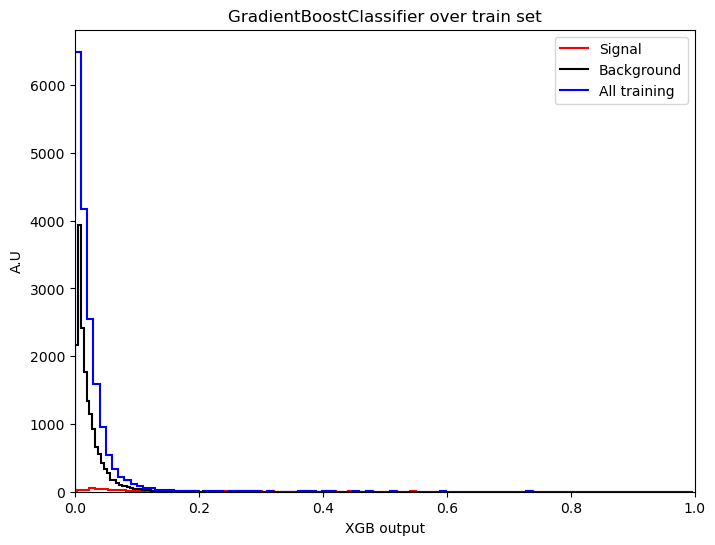

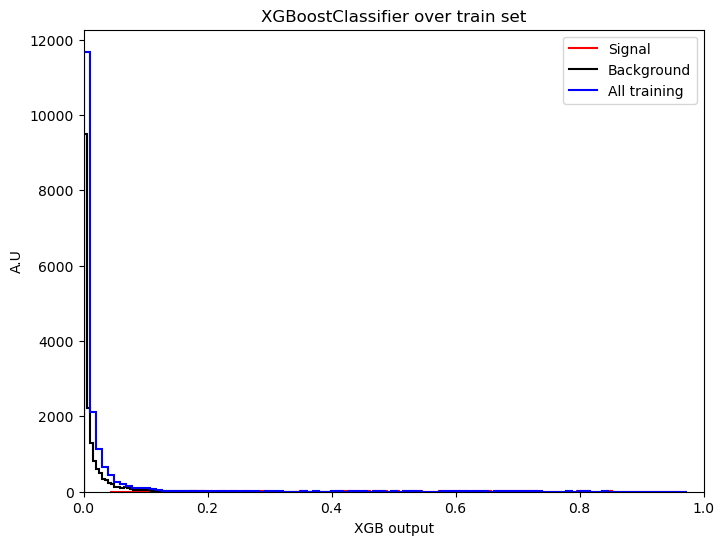

In [19]:
plt.figure(figsize=(8,6))
rml.plot("GBC", df_sig, label="Signal", color="r", density=False)
rml.plot("GBC", df_bkg, label="Background", color="k", density=False)
rml.plot("GBC", df_train_shuf, label="All training", color="b", density=False)
plt.xlabel(r"XGB output")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.title("GradientBoostClassifier over train set")
plt.legend()
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_GBC_output_train_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_GBC_output_train_all.pdf", dpi=300, bbox_inches='tight')

plt.figure(figsize=(8,6))
rml.plot("XGB", df_sig, label="Signal", color="r", density=False)
rml.plot("XGB", df_bkg, label="Background", color="k", density=False)
rml.plot("XGB", df_train_shuf, label="All training", color="b", density=False)
plt.xlabel(r"XGB output")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.title("XGBoostClassifier over train set")
plt.legend()
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_XGB_output_train_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_XGB_output_train_all.pdf", dpi=300, bbox_inches='tight')

The optimal cut value is 0.06 with and S/sqrt(S+B) of 89.65
The optimal cut value is 0.48 with and S/sqrt(S+B) of 76.37
The optimal cut value is 0.14 with and S/sqrt(S+B) of 134.43


Text(0.5, 1.0, 'XGBoostClassifier over train set')

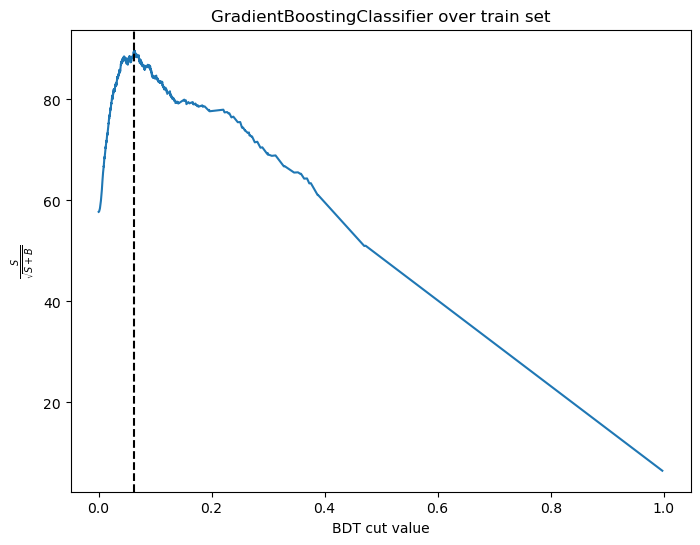

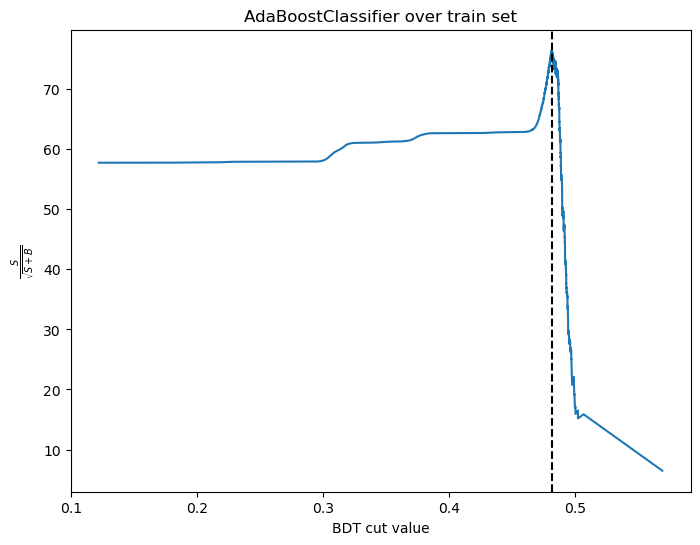

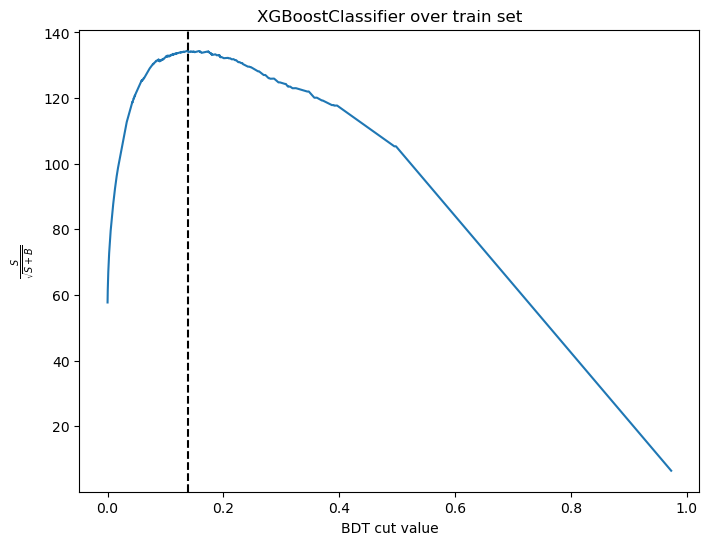

In [20]:
plt.figure(figsize=(8,6))
rml.FoM_plot(gbc ,df_train_shuf, training_features, "type", 2e4, 1e5)
plt.title("GradientBoostingClassifier over train set")

plt.figure(figsize=(8,6))
rml.FoM_plot(ada, df_train_shuf, training_features, "type", 2e4, 1e5)
plt.title("AdaBoostClassifier over train set")

plt.figure(figsize=(8,6))
rml.FoM_plot(xgb, df_train_shuf, training_features, "type", 2e4, 1e5)
plt.title("XGBoostClassifier over train set")


#### $M(D_s^+\pi^0)$ BDT cut try

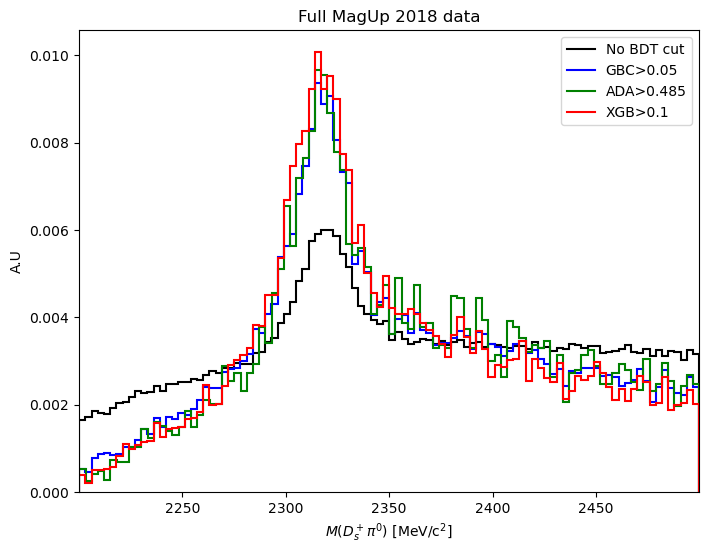

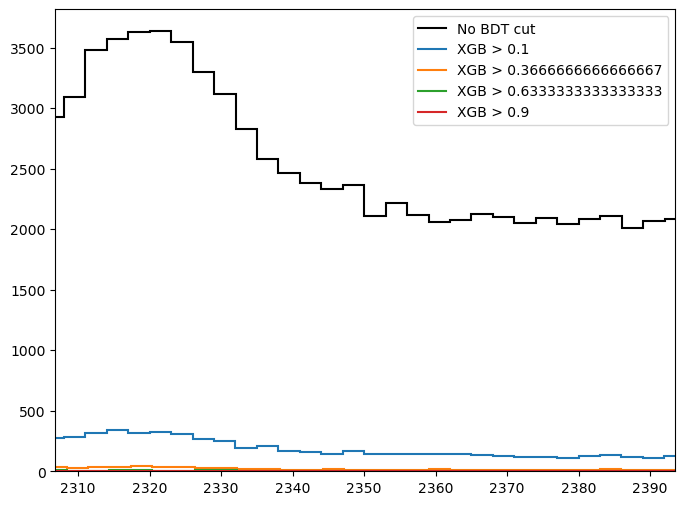

In [21]:
df_data_2 = df_data.query("Ds0M > 2200 & Ds0M < 2500")
df_data_GBC_cut = df_data_2.query("GBC > 0.05")
df_data_ADA_cut = df_data_2.query("ADA > 0.49")
df_data_XGB_cut = df_data_2.query("XGB > 0.1")

xgb_cuts = ["XGB > " + str(x) for x in np.linspace(0.1,0.9,4)]

plt.figure(1, figsize=(8,6))
rml.plot("Ds0M", df_data_2, label="No BDT cut", color="k", density=True)
rml.plot("Ds0M", df_data_GBC_cut, label="GBC>0.05", color="b", density=True)
rml.plot("Ds0M", df_data_ADA_cut, label="ADA>0.485", color="g", density=True)
rml.plot("Ds0M", df_data_XGB_cut, label="XGB>0.1", color="r", density=True)
plt.xlabel(r"$M(D_s^+\pi^0)$ $\mathrm{[MeV/c^2]} $")
plt.ylabel(r'A.U')
plt.title(r'Full MagUp 2018 data')
plt.legend()
if base:
    plt.savefig("Train_plots/Exp_MagU18_Dspi0L_mass_BDT_cuts_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Exp_MagU18_Dspi0L_mass_BDT_cuts_all.pdf", dpi=300, bbox_inches='tight')

colors = ["C"+str(i) for i in range(len(xgb_cuts))]

plt.figure(2, figsize=(8,6))
rml.plot("Ds0M", df_data_2, label="No BDT cut", color="k", density=False)
for i in range(len(xgb_cuts)):
    rml.plot("Ds0M", df_data_2.query(xgb_cuts[i]), label=xgb_cuts[i], color=colors[i], density=False)


### BDT efficiency

$$\varepsilon_{\mathrm{BDT}}=\frac{N_S(\mathrm{TRUEID}\cap\mathrm{presel}\cap\mathrm{BDT})}{N_S(\mathrm{TRUEID}\cap\mathrm{presel})}$$

$$u(\varepsilon_{\mathrm{BDT}})=\sqrt{\frac{\varepsilon_{\mathrm{BDT}}(1-\varepsilon_{\mathrm{BDT}})}{N_S(\mathrm{TRUEID}\cap\mathrm{presel})}}$$

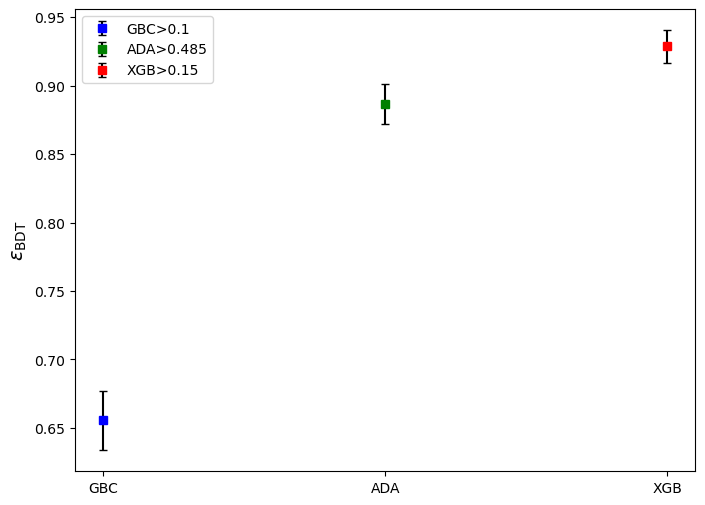

In [22]:
def ueff(eff,N):
    return np.sqrt(eff * (1-eff)/N)

eff_GBC = len((df_sig.query("GBC > 0.05"))["GBC"]) / len(df_sig["GBC"])
eff_ADA = len((df_sig.query("ADA > 0.48"))["ADA"]) / len(df_sig["ADA"])
eff_XGB = len((df_sig.query("XGB > 0.15"))["XGB"]) / len(df_sig["XGB"])

ueff_GBC = ueff(eff_GBC, len(df_sig["GBC"]))
ueff_ADA = ueff(eff_ADA, len(df_sig["ADA"]))
ueff_XGB = ueff(eff_XGB, len(df_sig["XGB"]))

algs=["GBC", "ADA", "XGB"]
plt.figure(figsize=(8,6))
plt.errorbar(1, eff_GBC, ueff_GBC, fmt="bs", ecolor="black", capsize=3, label="GBC>0.1")
plt.errorbar(2, eff_ADA, ueff_ADA, fmt="gs", ecolor="black", capsize=3, label="ADA>0.485")
plt.errorbar(3, eff_XGB, ueff_XGB, fmt="rs", ecolor="black", capsize=3, label="XGB>0.15")
plt.legend()
plt.xticks([1,2,3],algs)
plt.ylabel(r"$\varepsilon_{\mathrm{BDT}}$", fontsize=14)
if base:
    plt.savefig("Train_plots/Exp_MagU18_Dspi0L_mass_BDT_eff_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Exp_MagU18_Dspi0L_mass_BDT_eff_all.pdf", dpi=300, bbox_inches='tight')




<Figure size 1200x800 with 0 Axes>

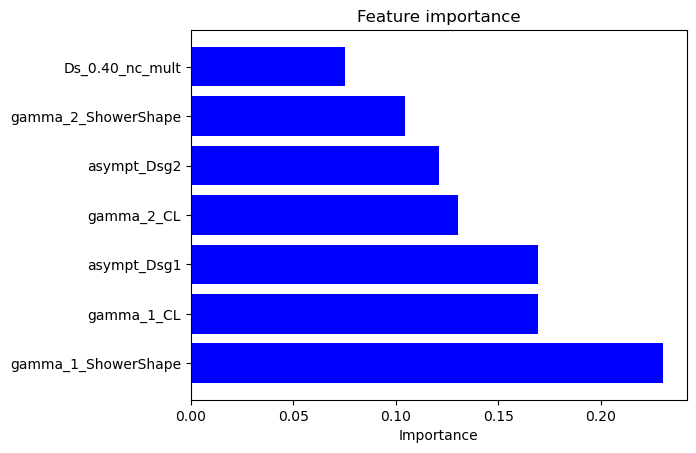

<Figure size 1200x800 with 0 Axes>

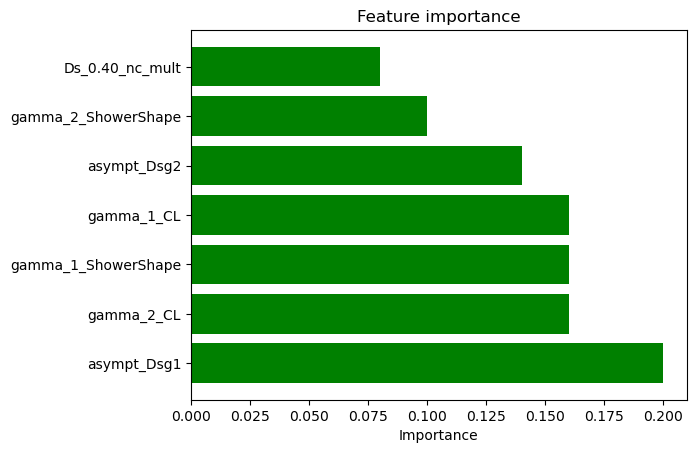

<Figure size 1200x800 with 0 Axes>

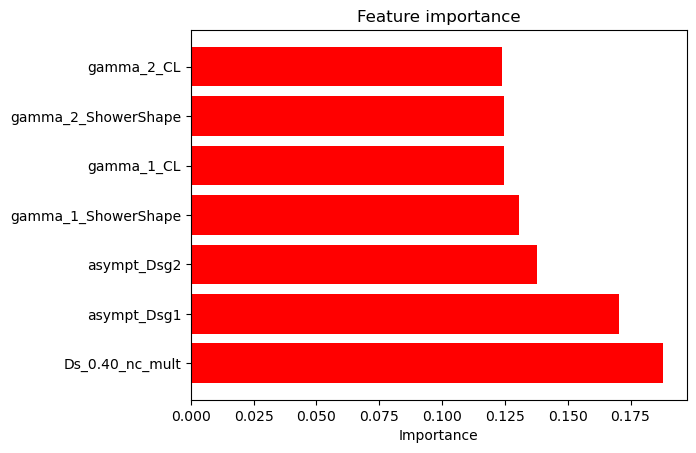

In [23]:
plt.figure(figsize=(12, 8))
rml.feature_importance_plot(gbc, training_features, color="blue")
plt.title(r"Feature importance")
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_GBC_feature_importance_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_GBC_feature_importance_all.pdf", dpi=300, bbox_inches='tight')

plt.figure(figsize=(12, 8))
rml.feature_importance_plot(ada, training_features, color="green")
plt.title(r"Feature importance")
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_ADA_feature_importance_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_ADA_feature_importance_all.pdf", dpi=300, bbox_inches='tight')

plt.figure(figsize=(12, 8))
rml.feature_importance_plot(xgb, training_features,color="red")
plt.title(r"Feature importance")
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_XGB_feature_importance_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_XGB_feature_importance_all.pdf", dpi=300, bbox_inches='tight')


### Training performance

#### Confusion matrix

In [24]:
df_train_shuf["GBC type pred"] = gbc.predict(df_train_shuf[training_features])
df_train_shuf["ADA type pred"] = ada.predict(df_train_shuf[training_features])
df_train_shuf["XGB type pred"] = xgb.predict(df_train_shuf[training_features])


conf_gbc = confusion_matrix(df_train_shuf["type"], df_train_shuf["GBC type pred"])
conf_ada = confusion_matrix(df_train_shuf["type"], df_train_shuf["ADA type pred"])
conf_xgb = confusion_matrix(df_train_shuf["type"], df_train_shuf["XGB type pred"])

confs = [conf_gbc, conf_ada, conf_xgb]
algs = ["GBC", "ADA", "XGB"]

for i in range(len(confs)):
    print("Confusion matrix for " + algs[i] + " algorithm")
    print(confs[i])

Confusion matrix for GBC algorithm
[[17189     0]
 [  420    56]]
Confusion matrix for ADA algorithm
[[17179    10]
 [  467     9]]
Confusion matrix for XGB algorithm
[[17189     0]
 [  214   262]]


#### ROC curve

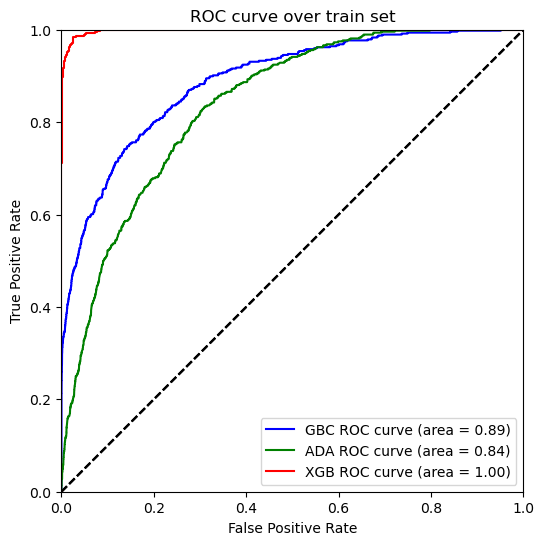

In [25]:
plt.figure(figsize=(8, 6))
rml.roc_curve_plot(gbc,df_train_shuf, training_features, 'type', label="GBC", color="blue")
rml.roc_curve_plot(ada,df_train_shuf, training_features, 'type', label="ADA", color="green")
rml.roc_curve_plot(xgb,df_train_shuf, training_features, 'type', label="XGB", color="red")
plt.title(r"ROC curve over train set")
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_BDT_roc_curve_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_BDT_roc_curve_all.pdf", dpi=300, bbox_inches='tight')



#### Precision vs recall

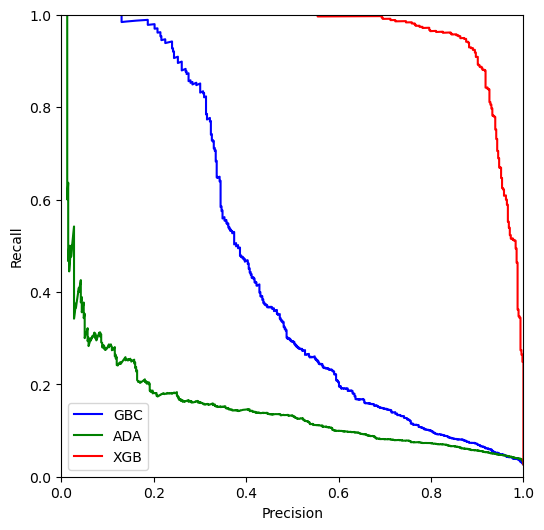

In [26]:
plt.figure(figsize=(8, 6))
rml.precision_recall_plot(gbc, df_train_shuf, training_features, 'type', label="GBC", color="blue")
rml.precision_recall_plot(ada, df_train_shuf, training_features, 'type', label="ADA", color="green")
rml.precision_recall_plot(xgb, df_train_shuf, training_features, 'type', label="XGB", color="red")
if base:
    plt.savefig("Train_plots/Comp_Dspi0L_BDT_precision_recall_base.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig("Train_plots/Comp_Dspi0L_BDT_precision_recall.pdf", dpi=300, bbox_inches='tight')



## $S/B$ improvement with the BDT applied

### Pandas dataframe to RDataFrame

In [27]:
new_tdf_data = rsh.pdf_to_rdf(df_data)
new_tdf_data_BDT_cut = new_tdf_data.Filter("XGB > 0.65")

### Fit strategy
#### Unbinned Extended Likelihood Fit (ELF) of 2 components

$$
	\mathcal{M}(M|\rho)=N_S\cdot\mathrm{PDF}_{S}(M|\rho_1)+N_{CoB}\cdot \mathrm{PDF}_{CoB}(M|\rho_3)
$$

where:
*  $\mathrm{PDF}_{S}$: PDF for the peak
*  $\mathrm{PDF}_{CoB}$: PDF for combinatorial background

#### For the peak we will use Crystal Ball model

 $$\mathrm{CB}\left(m ; m_0, \sigma, \alpha_L, n_L, \alpha_R, n_R\right)= \begin{cases}A_L \cdot\left(B_L-\frac{m-m_0}{\sigma_L}\right)^{-n_L}, & \text { for } \frac{m-m_0}{\sigma_L}<-\alpha_L \\ \exp \left(-\frac{1}{2} \cdot\left[\frac{m-m_0}{\sigma_L}\right]^2\right), & \text { for } \frac{m-m_0}{\sigma_L} \leq 0 \\ \exp \left(-\frac{1}{2} \cdot\left[\frac{m-m_0}{\sigma_R}\right]^2\right), & \text { for } \frac{m-m_0}{\sigma_R} \leq \alpha_R \\ A_R \cdot\left(B_R+\frac{m-m_0}{\sigma_R}\right)^{-n_R}, & \text { otherwise }\end{cases}$$

#### For the background we will use a 3º order Chebyshev polynomial

$$\mathrm{PDF}_{CoB}(M|\rho_3)=T_0(M)+aT_1(M)+bT_2(M)+cT_3(M)$$

$$T_{n+1}(x)=2xT_n(x)-T_{n-1}(x) \text{ with } n=1,2,3,\dots,\text{ } T_0=1,\text{ } T_1(x)=x$$


### RooRealVar and RooDataSet

In [28]:
np_tdf = new_tdf_data.Filter("Ds0M>2220 && Ds0M<2440").AsNumpy()
np_tdf_BDT = new_tdf_data_BDT_cut.Filter("Ds0M>2220 && Ds0M<2440").AsNumpy()

Nentries = new_tdf_data.Filter("Ds0M>2220 && Ds0M<2440").Count().GetValue()

Nentries_BDT = new_tdf_data_BDT_cut.Filter("Ds0M>2220 && Ds0M<2440").Count().GetValue()


In [29]:
m = ROOT.RooRealVar("Ds0M", "Ds0M", 2220, 2440)
g1_CL = ROOT.RooRealVar("gamma_1_CL", "gamma_1_CL", 0.5, 1)
g2_CL = ROOT.RooRealVar("gamma_2_CL", "gamma_2_CL", 0.5, 1)
g1_shape = ROOT.RooRealVar("gamma_1_ShowerShape", "gamma_1_ShowerShape", 0, 20000)
g2_shape = ROOT.RooRealVar("gamma_2_ShowerShape", "gamma_2_ShowerShape", 0, 20000)
g1_prs = ROOT.RooRealVar("gamma_1_Prs", "gamma_1_Prs", 0, 300)
g2_prs = ROOT.RooRealVar("gamma_2_Prs", "gamma_2_Prs", 0, 300)
Ds_nc_multi = ROOT.RooRealVar("Ds_0.40_nc_mult", "Ds_0.40_nc_mult", 0,14)
asympt_Dsg1 = ROOT.RooRealVar("asympt_Dsg1", "asympt_Dsg1", 0.5, 1)
asympt_Dsg2 = ROOT.RooRealVar("asympt_Dsg2", "asympt_Dsg2", 0.5, 1)
XGB = ROOT.RooRealVar("XGB", "XGB", 0, 1)


dataset = ROOT.RooDataSet.from_numpy(np_tdf, [m, g1_CL, g2_CL, g1_shape, g2_shape,
                                              g1_prs, g2_prs, Ds_nc_multi, asympt_Dsg1, asympt_Dsg2, XGB])

dataset_BDT = ROOT.RooDataSet.from_numpy(np_tdf_BDT,[m, g1_CL, g2_CL, g1_shape, g2_shape,
                                                     g1_prs, g2_prs, Ds_nc_multi, asympt_Dsg1, asympt_Dsg2, XGB])

### Crystal Ball model

 $$\mathrm{CB}\left(m ; m_0, \sigma, \alpha_L, n_L, \alpha_R, n_R\right)= \begin{cases}A_L \cdot\left(B_L-\frac{m-m_0}{\sigma_L}\right)^{-n_L}, & \text { for } \frac{m-m_0}{\sigma_L}<-\alpha_L \\ \exp \left(-\frac{1}{2} \cdot\left[\frac{m-m_0}{\sigma_L}\right]^2\right), & \text { for } \frac{m-m_0}{\sigma_L} \leq 0 \\ \exp \left(-\frac{1}{2} \cdot\left[\frac{m-m_0}{\sigma_R}\right]^2\right), & \text { for } \frac{m-m_0}{\sigma_R} \leq \alpha_R \\ A_R \cdot\left(B_R+\frac{m-m_0}{\sigma_R}\right)^{-n_R}, & \text { otherwise }\end{cases}$$




In [30]:
# initial parameters
mu_c = 2317
sigma_c = 15
alpha_c = 0.5
n_c = 4

In [31]:
mu = ROOT.RooRealVar("mu", "mu", mu_c, mu_c-50, mu_c+50)
sigma = ROOT.RooRealVar("sigma", "sigma", sigma_c, 0.2*sigma_c, 3*sigma_c)
alphaL = ROOT.RooRealVar("alphaL", "alphaL", alpha_c, 0.01*alpha_c, 20*alpha_c)
nL = ROOT.RooRealVar("nL", "nL", 10)
alphaR = ROOT.RooRealVar("alphaR", "alphaR", alpha_c, 0.01*alpha_c, 20*alpha_c)
nR = ROOT.RooRealVar("nR", "nR", 10)

CB = ROOT.RooCrystalBall("CB", "CB", m, mu, sigma, alphaL, nL, alphaR, nR)

units = ["No units", "No units", "MeV/$c^2$", "MeV/$c^2$"]
 

[#0] WARNING:InputArguments -- The parameter 'nL' with range [-1e+30, 1e+30] of the RooCrystalBall 'CB' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'nR' with range [-1e+30, 1e+30] of the RooCrystalBall 'CB' exceeds the safe range of (0, inf). Advise to limit its range.


### Combinatorial background PDF


In [32]:
a = ROOT.RooRealVar("a", "a", 0.3, -1.1, 1.1)
b = ROOT.RooRealVar("b", "b", -0.1, -1.1, 1.1)
c = ROOT.RooRealVar("c", "c", -0.01, -1.1, 1.1)

cheb = ROOT.RooChebychev("cheb", "cheb", m, ROOT.RooArgList(a, b, c))

### ELF model definition

In [33]:
NS = ROOT.RooRealVar("NS", "NS", 0, Nentries)
Ncomb = ROOT.RooRealVar("Ncomb", "Ncomb", 0, Nentries)

yields = [NS, Ncomb]
for i in range(len(yields)):
    yields[i].setError(np.sqrt(Nentries))

ext_model = ROOT.RooAddPdf("ext_model", "ext_model", ROOT.RooArgList(CB, cheb), ROOT.RooArgList(NS, Ncomb))

### Fit

In [34]:
comps = ["CB", "cheb"]
data_units = units + [" ", " ", " ", " ", " "]

xlabel = "#it{M(D_{s}^{+}#pi^{0})} [MeV/c^{2}]"
ylabel = "N_{events}"
title = "Data MagDown 2018"

colors = [ROOT.kRed, ROOT.kGreen+2]
data_title = "Data MagDown 2018"

#### No BDT cut

In [35]:
Fit_no_BDT_cut = rpf.Fit(ext_model.fitTo(dataset, ROOT.RooFit.Save()))

Fit_no_BDT_cut.print()

rpf.plot(m, dataset, ext_model, file_name="Graphs/Exp_MagD18_Ds0_mass_fit_CB_no_BDT_cut.pdf", comps=comps, comps_color=colors, xlabel=xlabel)
Fit_no_BDT_cut.save_to_csv(file_name="Results/Exp_MagD18_Ds0_mass_fit_CB_no_BDT_cut.csv")
Fit_no_BDT_cut.save_to_latex(m, dataset, ext_model, data_units, file_name="Tables/Exp_MagD18_Ds0_mass_fit_CB_no_BDT_cut.tex", fit_type="u")

EDM = 1.5094150017136874e-05
-log(L) minimum = -868020.59529894
final value of floating parameters
correlation matrix
covariance matrix
chi2/bins = 0.8463627343215627
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (CB,cheb)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 NS           7.76005e+04  3.93956e+02    0.00000e+00  1.55201e+05
     2 Ncomb        7.76005e+04  3.93956e+02    0.00000e+00  1.55201e+05
     3 a            3.00000e-01  2.20000e-01   -1.10000e+00  1.10000e+00
     4 alphaL       5.00000e-01  2.47500e-01    5.00000e-03  1.00000e+01
     5 alphaR       5.00000e-01  2.47500e-01    5.

Error in <TPad::TPad>: You must create a TCanvas before creating a TPad
Info in <TCanvas::Print>: pdf file Graphs/Exp_MagD18_Ds0_mass_fit_CB_no_BDT_cut.pdf has been created


In [36]:
SB_no_BDT = ROOT.RooFormulaVar("SB_no_BDT", "NS/Ncomb", ROOT.RooArgList(NS, Ncomb))
SB_no_BDT_val = SB_no_BDT.getVal()
SB_no_BDT_unc = SB_no_BDT.getPropagatedError(Fit_no_BDT_cut.result)

SSB_no_BDT = ROOT.RooFormulaVar("SSB_no_BDT", "NS/sqrt(NS+Ncomb)", ROOT.RooArgList(NS, Ncomb))
SSB_no_BDT_val = SSB_no_BDT.getVal()
SSB_no_BDT_unc = SSB_no_BDT.getPropagatedError(Fit_no_BDT_cut.result)

print("Purity S/B= " + str(SB_no_BDT_val) + "+-" + str(SB_no_BDT_unc))
print("Significance S/sqrt(S+B)= " + str(SSB_no_BDT_val) + "+-" + str(SSB_no_BDT_unc))

Purity S/B= 0.16061638522935429+-0.007962091567445274
Significance S/sqrt(S+B)= 54.519174993651426+-2.330037319016375


##### sPlot and sWeights

In [37]:
sData = ROOT.RooStats.SPlot('splot', "sPlot", dataset, ext_model, ROOT.RooArgList(NS, Ncomb))
dataset.Print()

df_data_sweights = pd.DataFrame(dataset.to_numpy())
df_data_sweights

Ds0M  gamma_1_CL  gamma_2_CL  gamma_1_ShowerShape  \
0       2414.143377    0.992792    0.980788           778.552551   
1       2435.877487    0.799012    0.726779          2373.925293   
2       2278.233458    0.682852    0.788760          2426.484863   
3       2305.754959    0.713758    0.701809          1165.424072   
4       2319.160925    0.943508    0.619245           872.538513   
...             ...         ...         ...                  ...   
155196  2337.837064    0.906754    0.733375          2216.016602   
155197  2288.268168    0.884281    0.964677          1351.970337   
155198  2347.303924    0.877247    0.886316           622.148865   
155199  2275.128669    0.988528    0.975040          1419.788330   
155200  2330.800447    0.841784    0.904740          5637.143555   

        gamma_2_ShowerShape  gamma_1_Prs  gamma_2_Prs  Ds_0.40_nc_mult  \
0                684.779724    15.907762    89.412590              3.0   
1               2076.037109    82.281525   159.626160              3.0   
2               1644.402100    71.310654    63.905319              4.0   
3               2843.636475    12.616501   109.982971              4.0   
4               1480.381348   217.497498   139.878586              2.0   
...                     ...          ...          ...              ...   
155196          3003.631104    61.436871   148.655289              3.0   
155197           919.661255    96.269386   125.890732              2.0   
155198           962.096436    21.118925   125.067917              4.0   
155199          1244.494629    17.553392     7.679609              4.0   
155200          7743.032227    25.781544    36.752415              2.0   

        asympt_Dsg1  asympt_Dsg2       XGB     NS_sw      L_NS  Ncomb_sw  \
0          0.610574     0.586601  0.000749 -0.421929  0.000074  1.421932   
1          0.874658     0.718552  0.003416 -0.428171  0.000026  1.428175   
2          0.837315     0.901583  0.001803 -0.193571  0.001607  1.193574   
3          0.769723     0.847238  0.000901  1.034875  0.015694 -0.034874   
4          0.657957     0.889532  0.013645  1.570582  0.027662 -0.570582   
...             ...          ...       ...       ...       ...       ...   
155196     0.621436     0.752331  0.007409  0.567387  0.009676  0.432615   
155197     0.865079     0.797225  0.014306  0.037896  0.003481  0.962107   
155198     0.835590     0.707909  0.006127  0.103882  0.004574  0.896120   
155199     0.873270     0.805101  0.019517 -0.237777  0.001280  1.237781   
155200     0.829779     0.768882  0.031429  1.086603  0.017444 -0.086602   

         L_Ncomb  
0       0.005042  
1       0.004963  
2       0.004207  
3       0.004559  
4       0.004698  
...          ...  
155196  0.004854  
155197  0.004346  
155198  0.004916  
155199  0.004161  
155200  0.004800  

[155201 rows x 15 columns]

[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (CB,cheb)
[#1] INFO:Fitting -- RooAbsPdf::fitTo(ext_model) Calculating sum-of-weights-squared correction matrix for covariance matrix
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization
[#1] INFO:InputArguments -- yield in pdf: NS 21477.8
[#1] INFO:InputArguments -- yield in pdf: Ncomb 133724
[#1] INFO:Eval -- Calculating sWeight
RooDataSet::[Ds0M,gamma_1_CL,gamma_2_CL,gamma_1_ShowerShape,gamma_2_ShowerShape,gamma_1_Prs,gamma_2_Prs,Ds_0.40_nc_mult,asympt_Dsg1,asympt_Dsg2,XGB,NS_sw,L_NS,Ncomb_sw,L_Ncomb] = 155201 entries


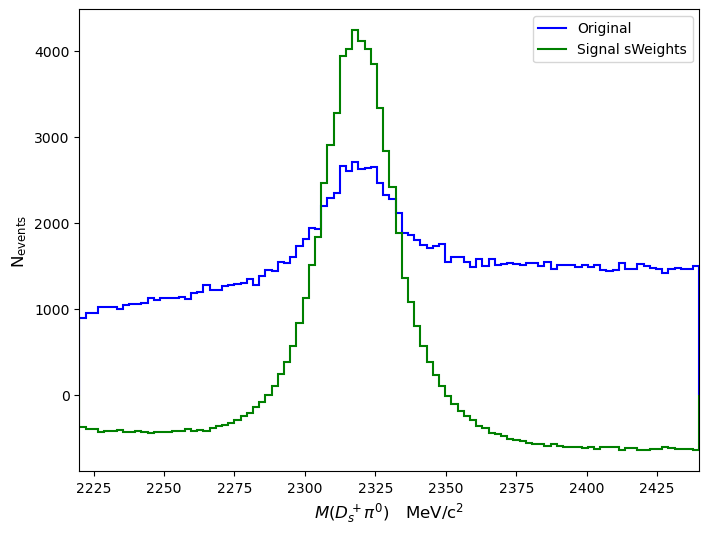

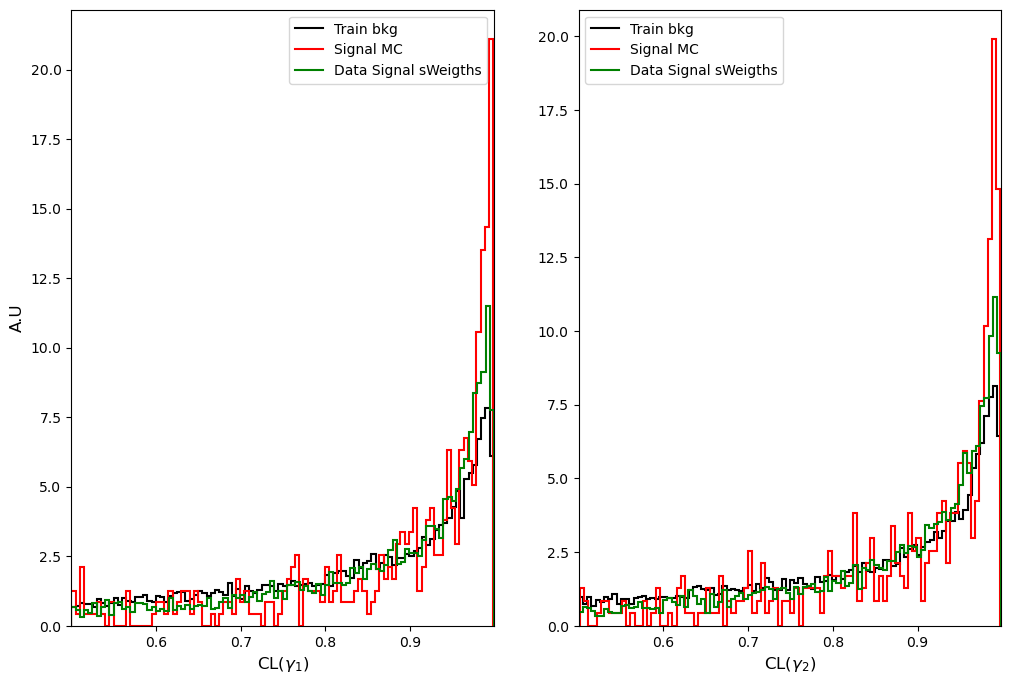

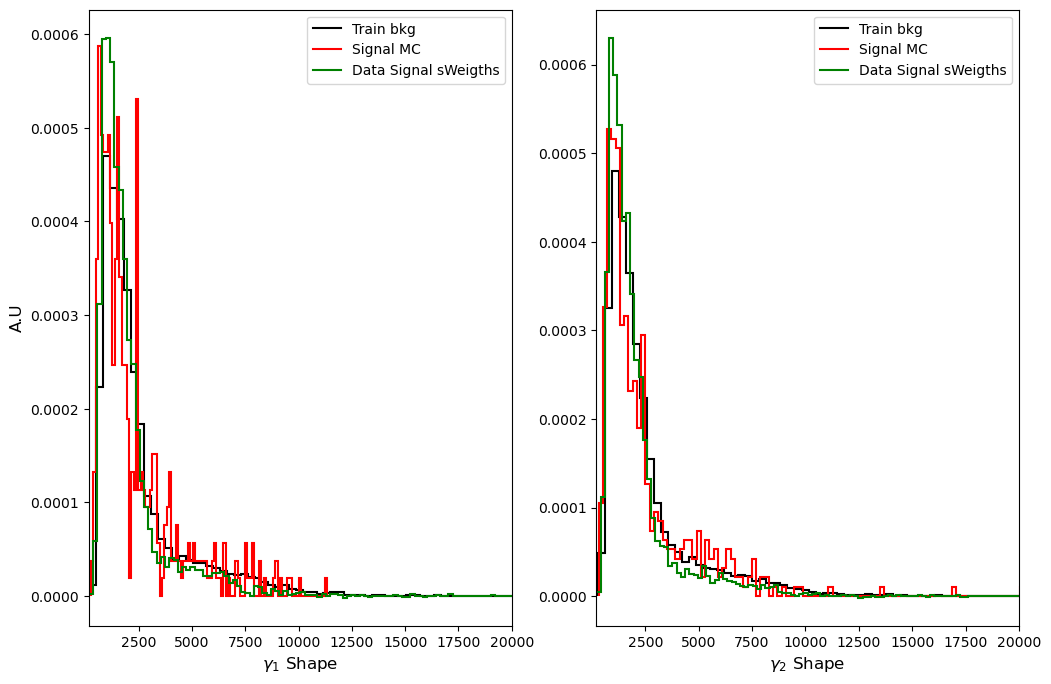

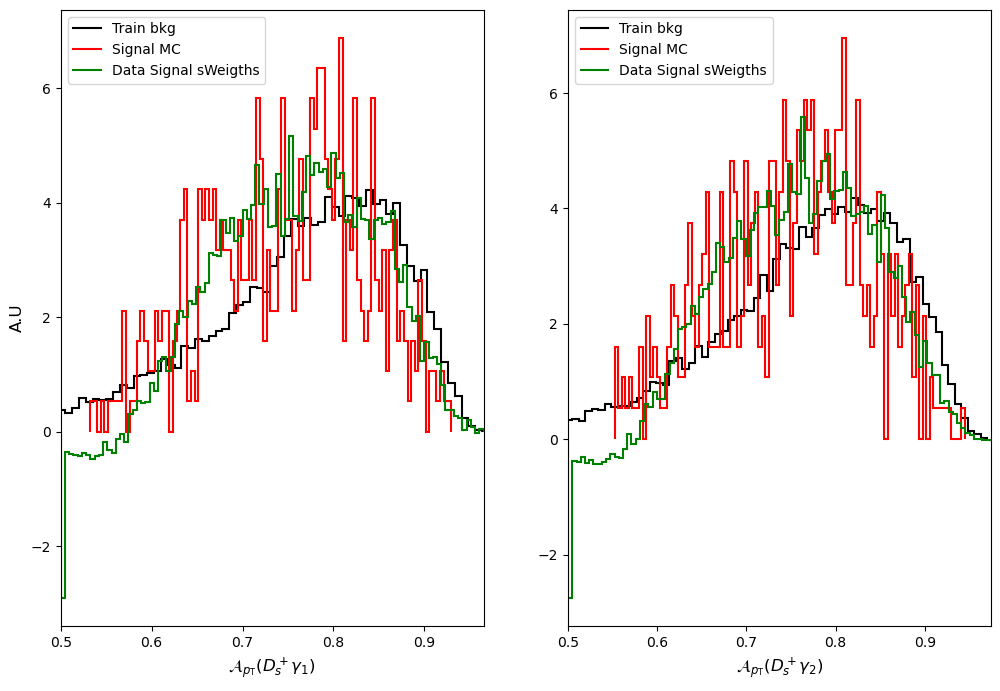

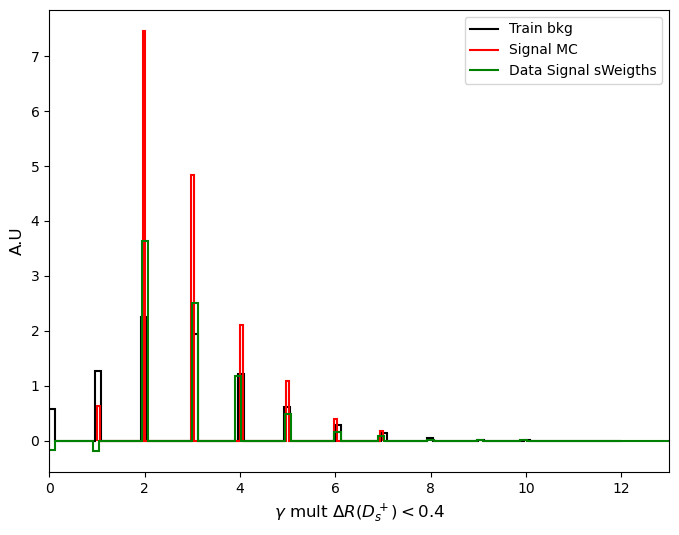

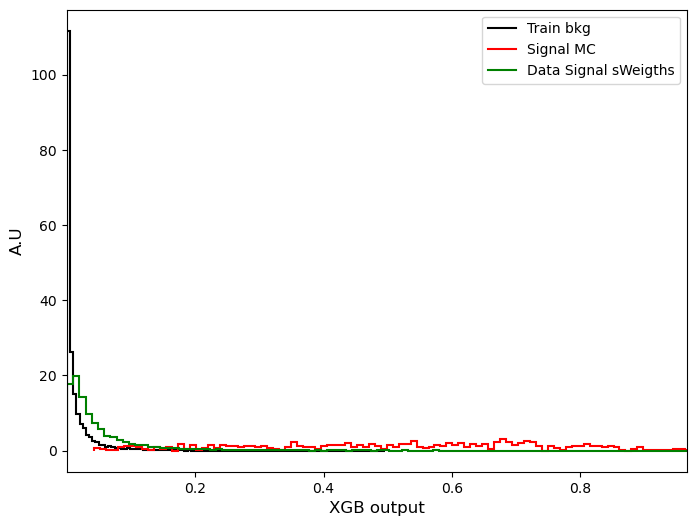

In [38]:
plt.figure(figsize=(8,6))
rml.plot("Ds0M", df_data_sweights, color="blue", label="Original", density=False)
rml.plot("Ds0M", df_data_sweights, color="green", label="Signal sWeights", density=False, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"$M(D_s^+\pi^0) \quad \mathrm{MeV/c^2}$", fontsize=12) 
plt.ylabel(r"$\mathrm{N_{events}}$", fontsize=12)
plt.savefig("Plots_comp/Comp_Dspi0L_mass_sWeights.pdf", dpi=300, bbox_inches="tight")

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
rml.plot("gamma_1_CL", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("gamma_1_CL", df_sig, color="red", label="Signal MC", density=True)
rml.plot("gamma_1_CL", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"CL$(\gamma_1)$", fontsize=12)
plt.ylabel(r"A.U", fontsize=12)
plt.subplot(1, 2, 2)
rml.plot("gamma_2_CL", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("gamma_2_CL", df_sig, color="red", label="Signal MC", density=True)
rml.plot("gamma_2_CL", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"CL$(\gamma_2)$", fontsize=12)
plt.savefig("Plots_comp/Comp_Dspi0L_gamma_CL_sWeights.pdf", dpi=300, bbox_inches="tight")


plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
rml.plot("gamma_1_ShowerShape", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("gamma_1_ShowerShape", df_sig, color="red", label="Signal MC", density=True)
rml.plot("gamma_1_ShowerShape",df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"$\gamma_1$ Shape", fontsize=12)
plt.ylabel(r"A.U", fontsize=12)
plt.subplot(1, 2, 2)
rml.plot("gamma_2_ShowerShape", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("gamma_2_ShowerShape", df_sig, color="red", label="Signal MC", density=True)
rml.plot("gamma_2_ShowerShape", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"$\gamma_2$ Shape", fontsize=12) 
plt.savefig("Plots_comp/Comp_Dspi0L_gamma_shape_sWeights.pdf", dpi=300, bbox_inches="tight")

plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
rml.plot("asympt_Dsg1", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("asympt_Dsg1", df_sig, color="red", label="Signal MC", density=True)
rml.plot("asympt_Dsg1", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"$\mathcal{A}_{p_{\mathrm{T}}}(D_s^+\gamma_1)$", fontsize=12)
plt.ylabel(r"A.U", fontsize=12)
plt.subplot(1, 2, 2)
rml.plot("asympt_Dsg2", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("asympt_Dsg2", df_sig, color="red",label="Signal MC", density=True)
rml.plot("asympt_Dsg2", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"$\mathcal{A}_{p_{\mathrm{T}}}(D_s^+\gamma_2)$", fontsize=12)
plt.savefig("Plots_comp/Comp_Dspi0L_asympt_Dsg_sWeights.pdf", dpi=300, bbox_inches="tight")
 
plt.figure(figsize=(8,6))
rml.plot("Ds_0.40_nc_mult", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("Ds_0.40_nc_mult", df_sig, color="red", label="Signal MC", density=True)
rml.plot("Ds_0.40_nc_mult", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"$\gamma$ mult $\Delta R(D_s^+)<0.4$", fontsize=12)
plt.ylabel(r"A.U", fontsize=12)
plt.savefig("Plots_comp/Comp_Dspi0L_Ds_nc_mult_sWeights.pdf", dpi=300, bbox_inches="tight")

plt.figure(figsize=(8,6))
rml.plot("XGB", df_bkg, color="black", label="Train bkg", density=True)
rml.plot("XGB", df_sig, color="red", label="Signal MC", density=True)
rml.plot("XGB", df_data_sweights, color="green", label="Data Signal sWeigths", density=True, weights=df_data_sweights["NS_sw"])
plt.xlabel(r"XGB output", fontsize=12)
plt.ylabel(r"A.U", fontsize=12)
plt.savefig("Plots_comp/Comp_Dspi0L_XGB_output_sWeights.pdf", dpi=300, bbox_inches="tight")


#### BDT cut

In [39]:
Fit_BDT_cut = rpf.Fit(ext_model.fitTo(dataset_BDT, ROOT.RooFit.Save()))

Fit_BDT_cut.print()
rpf.plot(m, dataset_BDT, ext_model, file_name="Graphs/Exp_MagD18_Ds0_mass_fit_CB_BDT_cut.pdf", comps=comps, comp_colors=colors, xlabel=xlabel)
Fit_BDT_cut.save_to_csv(file_name="Results/Exp_MagD18_Ds0_mass_fit_CB_BDT_cut.csv")
Fit_BDT_cut.save_to_latex(m, dataset, ext_model, data_units, file_name="Tables/Exp_MagD18_Ds0_mass_fit_CB_BDT_cut.tex", fit_type="u")


EDM = 0.00011157585570077065
-log(L) minimum = 164.8052320868602
final value of floating parameters
correlation matrix
covariance matrix
chi2/bins = 0.3763727026381561
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (CB,cheb)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 NS           2.14778e+04  2.81403e+02    0.00000e+00  1.55201e+05
     2 Ncomb        1.33724e+05  4.37511e+02    0.00000e+00  1.55201e+05
     3 a            2.02038e-01  5.69181e-03   -1.10000e+00  1.10000e+00
     4 alphaL       1.14186e+00  1.10199e-01    5.00000e-03  1.00000e+01
     5 alphaR       1.06640e+00  8.84380e-02    5

Error in <TPad::TPad>: You must create a TCanvas before creating a TPad
Info in <TCanvas::Print>: pdf file Graphs/Exp_MagD18_Ds0_mass_fit_CB_BDT_cut.pdf has been created


In [40]:
SB_BDT = ROOT.RooFormulaVar("SB_BDT", "NS/Ncomb", ROOT.RooArgList(NS, Ncomb))
SB_BDT_val = SB_BDT.getVal()
SB_BDT_unc = SB_BDT.getPropagatedError(Fit_BDT_cut.result)

SSB_BDT = ROOT.RooFormulaVar("SSB_BDT", "NS/sqrt(NS+Ncomb)", ROOT.RooArgList(NS,Ncomb))
SSB_BDT_val = SSB_BDT.getVal()
SSB_BDT_unc = SSB_BDT.getPropagatedError(Fit_BDT_cut.result)


print("Purity S/B = " + str(SB_BDT_val) + "+-" + str(SB_BDT_unc))
print("Significance S/sqrt(S+B)= " + str(SSB_BDT_val) + "+-" + str(SSB_BDT_unc))

Purity S/B = 0.8787498678535314+-0.14882922329277054
Significance S/sqrt(S+B)= 5.804202086722272+-1.1198825555914107


In [41]:
Pur_improve = SB_BDT_val / SB_no_BDT_val
Signi_improve = SSB_BDT_val / SSB_no_BDT_val

print("S/B improvement with the BDT output cut: " + str(Pur_improve*100)+"%")
print("S/sqrt(S+B) improvement with the BDT output cut: " + str(Signi_improve*100)+"%")

S/B improvement with the BDT output cut: 547.1109728927773%
S/sqrt(S+B) improvement with the BDT output cut: 10.646166394480753%
